# The K-Means clustering algorithm
Two version are presented here.   The first is Python Numpy operators and the second is using Googles Tensorflow.   The speedup results at the end are based on a 16-core virtual machine runing on a 16 core big memory server on Azure.

## A revised version
This is a revised version of the one first published in the blog.  This one is based on the excellent example from Shawn Simister that is on github at https://gist.github.com/narphorium/d06b7ed234287e319f18.  Shawn's version is better documented and about 20% faster when N is 10000000. 

## note the data used is based on a simple anular array of points.   
This set has no natural clustering so by picking for starting points it will cluster it into four segments as shown below.  pick another four points and you will get a different set of segments.   also note that a bad choice for one point may give it no cluster and an error will happen.

In [28]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
from numpy import linalg as la
import time

In [29]:

#X is an array of N points in the plane
N = 1000 #  tested up to size 100000000
X = np.zeros(shape=(N,2))
for i in range(N):
    theta = 2*3.1417*random.random()
    dispx = 0.2*(random.random()-0.5)
    dispy = 0.2*(random.random()-0.5)
    X[i][0] = np.cos(theta)+dispx
    X[i][1] = np.sin(theta)+dispy

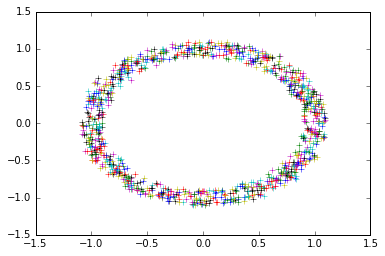

In [30]:
for x in X[:1000]:
    plt.plot(x[0],x[1], '+')

In [31]:
k = 4
kPoints0 = [[2., 1.], [0., 2.], [-1., 0], [0,-1.]]
oldpts = kPoints0
eps = 0.1

In [32]:
Xtrans = X.transpose()

In [33]:
def distance(P, Y):
    best = []
    for p in P:
        far = 100.0
        isave = -1
        for i in range(k):
            q = p-Y[i]
            d = np.vdot(q,q)
            if d < far:
                far = d
                isave = i
        best.extend([isave])
    return best
            

In [34]:
def ndist(P,Y):
    z = np.zeros([k,N])
    for i in range(k):
        w =P-Y[i]
        q = (w*w).transpose()
        z[:][i]= q[0]+q[1]
    return np.argmin(z,0)

In [35]:
#ndist(X, kPoints0)

In [36]:
def comperr(x,y):
    err = 0.0
    for i in range(len(x)):
        err += (x[i][0]-y[i][0])*(x[i][0]-y[i][0])+ (x[i][1]-y[i][1])*(x[i][1]-y[i][1])
    print err

In [37]:
def fun(x,y):
    if x == y:
        return 1
    return 0

In [38]:
t1 = time.time()
for i in range(20):
    oldpts = kPoints0
    dist = ndist(X, kPoints0)
    #v = [[(1,0)[d==j] for d in dist] for j in range(k)]
    #print v
    v = [[fun(d,j) for d in dist] for j in range(k)]
    sums = [np.sum(v[i]) for i in range(k)]
    sumx = [[np.sum(v[i]*(Xtrans[j]))/sums[i] for i in range(k)] for j in range(2)]
    kPoints0 = np.array(sumx).transpose()
    comperr(kPoints0,oldpts)

tser = time.time()-t1

2.9441553248
0.0510923662302
0.0141640915003
0.00591481163566
0.00477784907502
0.00192763545446
0.000447812865755
0.00021347813838
9.84760126953e-05
8.93224943376e-05
1.88646808936e-05
1.62432593542e-05
1.84621840859e-05
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [39]:
kPoints0

array([[ 0.89632941,  0.22612033],
       [-0.15659479,  0.89010502],
       [-0.87541038, -0.20097509],
       [ 0.27672717, -0.85508781]])

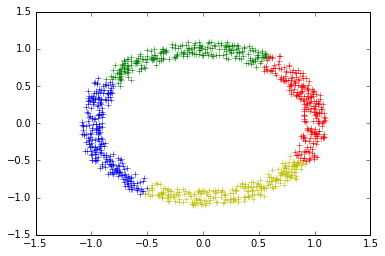

In [40]:
col = ['r+','g+','b+','y+']
i = 0
for x in X[:1000]:
    plt.plot(x[0],x[1], col[dist[i]])
    i +=1

In [41]:
Xv = tf.constant(X, tf.float64, name="point")

In [42]:
#sess = tf.Session()

In [43]:
kPoints = [[np.float64(2.), np.float64(1.)], [np.float64(0.), np.float64(2.)], 
           [np.float64(-1.), np.float64(0)], [np.float64(0),np.float64(-1.)]]
dones = tf.fill([N,2], np.float64(1.))

In [44]:
initvals = tf.constant(kPoints, tf.float64)
centroids = tf.Variable(initvals)
oldcents = tf.Variable(initvals)
myarray = tf.Variable( tf.constant(1.0, shape = [2,3]))

In [45]:
centroids.dtype

tf.float64_ref

In [46]:
expanded_vectors = tf.expand_dims(Xv, 0)
expanded_centroids = tf.expand_dims(centroids, 1)
distances = tf.reduce_sum(tf.square(tf.sub(expanded_vectors, expanded_centroids)), 2)
assignments = tf.argmin(distances, 0)
sums = tf.unsorted_segment_sum(Xv, assignments, k)
totals = tf.unsorted_segment_sum(dones, assignments, k)
means = tf.div(sums,totals)
#vals_oldcents = tf.assign(oldcents, centroids)
vals_cents = tf.assign(centroids, means)
#leap = tf.sub(centroids,oldcents)


In [49]:
t1 = time.time()
#centroids = initvals
oldkPoints = np.zeros((4,2))
point_locs = np.zeros((N))
with tf.Session() as sess:
    init =tf.initialize_all_variables()
    sess.run(init)
    for i in range(20):
        _, kPoints, point_locs= sess.run([vals_cents, centroids, assignments])
        diff = kPoints-oldkPoints
        diffssq = np.sum( np.reshape(diff*diff, (8)))
        print np.sqrt(diffssq)
        oldkPoints = kPoints
ttensor = time.time()-t1

1.79941322278
0.226036205574
0.119012988788
0.0769078125789
0.0691219869146
0.0439048454553
0.0211615893958
0.0146108910878
0.00992350808411
0.00945105784225
0.00434334904119
0.00403029271322
0.00429676437403
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [50]:
kPoints

array([[ 0.89632941,  0.22612033],
       [-0.15659479,  0.89010502],
       [-0.87541038, -0.20097509],
       [ 0.27672717, -0.85508781]])

In [51]:
kPoints0

array([[ 0.89632941,  0.22612033],
       [-0.15659479,  0.89010502],
       [-0.87541038, -0.20097509],
       [ 0.27672717, -0.85508781]])

In [52]:
print "time = "+str(ttensor)

time = 0.443099021912


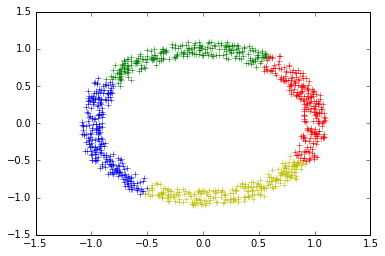

In [53]:
col = ['r+','g+','b+','y+']
i = 0
for x in X[:1000]:
    plt.plot(x[0],x[1], col[point_locs[i]])
    i +=1